In [18]:
import os
from logging import critical

import numpy as np
import torchvision.transforms

In [19]:
import pickle

DATA_DIR = 'data/cifar-10-batches-py'
LABEL_FILE = 'batches.meta'
TEST_DATA = 'test_batch'

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

def load_cifar_batches(data_dir):
    """Load all training batches and the metadata."""

    all_data = []
    all_labels = []

    for i in range(1, 6):
        file_path = os.path.join(data_dir, f'data_batch_{i}')
        batch_dict = unpickle(file_path)

        # Keys are stored as bytes, so we need to decode them
        data = batch_dict[b'data']
        labels = batch_dict[b'labels']

        all_data.append(data)
        all_labels.extend(labels)

    X_train = np.concatenate(all_data)
    y_train = np.array(all_labels)

    # Load Test Data
    test_file_path = os.path.join(data_dir, TEST_DATA)
    test_dict = unpickle(test_file_path)
    X_test = test_dict[b'data']
    y_test = np.array(test_dict[b'labels'])

    # Load Metadata (Class Names)
    meta_file_path = os.path.join(data_dir, LABEL_FILE)
    meta_dict = unpickle(meta_file_path)
    class_names = [name.decode('utf-8') for name in meta_dict[b'label_names']]

    return X_train, y_train, X_test, y_test, class_names

X_train, y_train, X_test, y_test, class_names = load_cifar_batches(DATA_DIR)

In [20]:
print(f"Dataset X_train shape: {X_train.shape}")
print(f"Dataset y_train shape: {y_train.shape}")
print(f"Test dataset X_test shape: {X_test.shape}")
print(f"Test dataset y_test shape: {y_test.shape}")
print(f"Classes number: {len(class_names)}")

Dataset X_train shape: (50000, 3072)
Dataset y_train shape: (50000,)
Test dataset X_test shape: (10000, 3072)
Test dataset y_test shape: (10000,)
Classes number: 10


In [21]:
print(f"Total training samples: {X_train.shape[0]}")
print(f"Shape of one image: {X_train.shape[1]} (32 * 32 * 3)")
print(f"Class names: {class_names}")

# Example: Reshape a single image to see its dimensions
# The 3072 pixels are stored as (R-channel, G-channel, B-channel)
# Each channel has 1024 pixels (32x32)
example_image = X_train[0].reshape(3, 32, 32).transpose(1, 2, 0) # Transpose for (H, W, C)
print(f"Shape of first image after reshaping: {example_image.shape}")
print(f"Label of first image: {class_names[y_train[0].item()]}")

Total training samples: 50000
Shape of one image: 3072 (32 * 32 * 3)
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Shape of first image after reshaping: (32, 32, 3)
Label of first image: frog


In [22]:
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Cifar10RawDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_data = self.data[idx]
        label = self.labels[idx]

        # Reshape the flattened image: (3072,) -> (3, 32, 32)
        # and convert to a NumPy array for compatibility with torchvision.transforms
        image = image_data.reshape(3, 32, 32).transpose(1, 2, 0)

        # Apply the transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
# CIFAR-10 standard mean and standard deviation
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

# Training Transformations (includes augmentation)
train_transform = transforms.Compose([
    transforms.ToPILImage(),    # Convert HWC NumPy array to PIL image
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomCrop(32, padding=4),   # Augmentation
    transforms.ToTensor(),      # Convert PIL image to Tensor
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD) # Scales to [0, 1]
])

# Testing/Validation Transformation (no augmentation)
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [24]:
# Transform data in a different approach
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0), ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

In [25]:
# Create Datasets
train_dataset = Cifar10RawDataset(X_train, y_train, train_transform)
test_dataset = Cifar10RawDataset(X_test, y_test, test_transform)

# Create DataLoaders
BATCH_SIZE = 64
NUM_OF_WORKERS = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_OF_WORKERS)

In [26]:
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of training data points: {len(train_loader.dataset)}")

Number of training batches: 782
Number of training data points: 50000


In [27]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [28]:
class ResNet18Block(nn.Module):
    """Basic residual block for ResNet-18/34."""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNet18Block, self).__init__()

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Second conv layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)

        return out

In [29]:
class ResNet18(nn.Module):
    """ResNet 18 architecture adapted for CIFAR-10."""

    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()

        # Initial convolution - adapted for CIFAR-10's 32x32 images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []

        # First block may downsample
        layers.append(ResNet18Block(in_channels, out_channels, stride=stride))

        # Remaining blocks
        for _ in range(1, num_blocks):
            layers.append(ResNet18Block(out_channels, out_channels, stride=1))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [30]:
# ==================== Data Preparation ====================
def get_data_loader(batch_size=128):
    """Prepare CIFAR-10 data loader with augmentation."""

    # Data augmentation for training
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                           std=[0.2470, 0.2435, 0.2616]),
    ])

    # No augmentation for validation/test
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                           std=[0.2470, 0.2435, 0.2616])
    ])

    # Load datasets
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

    # Split training into train and validation
    train_size = int(0.9 * len(trainset))
    val_size = len(trainset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2, pin_memory=True)
    test_loader = DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader

In [31]:
# ==================== Training Functions ====================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs)
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'accuracy': 100. * correct / total
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total

    return epoch_loss, epoch_accuracy

In [32]:
def validate(model, val_loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc='Validating'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

In [33]:
def test(model, test_loader, criterion, device):
    """Test the model and compute per-class accuracy."""
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10

    classes = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label)
                class_total[label] += 1

    overall_acc = 100. * correct / total
    print(f"\nOverall Accuracy: {overall_acc:.2f}%")
    print(f"\nPer-class Accuracy:")
    for i in range(10):
        acc = 100. * class_correct[i] / class_total[i]
        print(f"{classes[i]:>10s}: {acc:.2f}%")

    return overall_acc

Preparing data loaders...


C:\Users\yuanz\miniconda3\envs\deep-learning\Lib\site-packages\torch\optim\lr_scheduler.py:575: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Initializing ResNet-18 model...

Starting training...

Epoch 1/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Train Loss: 1.9702, Train Accuracy: 28.21%
Val Loss: 1.6848, Val Accuracy: 38.28%
Model saved! Best Val Accuracy: 38.28%

Epoch 2/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Train Loss: 1.4315, Train Accuracy: 47.49%
Val Loss: 1.3965, Val Accuracy: 48.74%
Model saved! Best Val Accuracy: 48.74%

Epoch 3/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


Train Loss: 1.1094, Train Accuracy: 59.99%
Val Loss: 1.1396, Val Accuracy: 60.26%
Model saved! Best Val Accuracy: 60.26%

Epoch 4/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Train Loss: 0.8613, Train Accuracy: 69.76%
Val Loss: 1.0090, Val Accuracy: 65.78%
Model saved! Best Val Accuracy: 65.78%

Epoch 5/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Train Loss: 0.7172, Train Accuracy: 75.08%
Val Loss: 1.0076, Val Accuracy: 66.80%
Model saved! Best Val Accuracy: 66.80%

Epoch 6/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Train Loss: 0.6337, Train Accuracy: 78.11%
Val Loss: 0.7029, Val Accuracy: 76.58%
Model saved! Best Val Accuracy: 76.58%

Epoch 7/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Train Loss: 0.5763, Train Accuracy: 80.03%
Val Loss: 0.6158, Val Accuracy: 79.44%
Model saved! Best Val Accuracy: 79.44%

Epoch 8/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.5386, Train Accuracy: 81.44%
Val Loss: 0.6854, Val Accuracy: 76.82%

Epoch 9/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Train Loss: 0.5093, Train Accuracy: 82.51%
Val Loss: 0.6325, Val Accuracy: 78.54%

Epoch 10/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.88it/s]


Train Loss: 0.4923, Train Accuracy: 83.13%
Val Loss: 0.7866, Val Accuracy: 74.08%

Epoch 11/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.57it/s]


Train Loss: 0.4751, Train Accuracy: 83.72%
Val Loss: 0.6715, Val Accuracy: 77.10%

Epoch 12/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Train Loss: 0.4585, Train Accuracy: 84.19%
Val Loss: 0.9108, Val Accuracy: 70.00%

Epoch 13/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Train Loss: 0.4468, Train Accuracy: 84.79%
Val Loss: 0.7179, Val Accuracy: 75.24%

Epoch 14/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.71it/s]


Train Loss: 0.4359, Train Accuracy: 85.04%
Val Loss: 0.5657, Val Accuracy: 81.50%
Model saved! Best Val Accuracy: 81.50%

Epoch 15/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Train Loss: 0.4264, Train Accuracy: 85.42%
Val Loss: 0.5637, Val Accuracy: 80.24%

Epoch 16/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Train Loss: 0.4131, Train Accuracy: 85.81%
Val Loss: 0.6674, Val Accuracy: 78.10%

Epoch 17/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Train Loss: 0.4099, Train Accuracy: 85.97%
Val Loss: 0.5533, Val Accuracy: 81.64%
Model saved! Best Val Accuracy: 81.64%

Epoch 18/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.32it/s]


Train Loss: 0.4007, Train Accuracy: 86.18%
Val Loss: 0.5360, Val Accuracy: 82.22%
Model saved! Best Val Accuracy: 82.22%

Epoch 19/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.59it/s]


Train Loss: 0.3882, Train Accuracy: 86.67%
Val Loss: 0.6542, Val Accuracy: 78.78%

Epoch 20/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.66it/s]


Train Loss: 0.3889, Train Accuracy: 86.63%
Val Loss: 0.6296, Val Accuracy: 80.92%

Epoch 21/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Train Loss: 0.3908, Train Accuracy: 86.55%
Val Loss: 0.4845, Val Accuracy: 83.32%
Model saved! Best Val Accuracy: 83.32%

Epoch 22/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.49it/s]


Train Loss: 0.3801, Train Accuracy: 87.13%
Val Loss: 0.5545, Val Accuracy: 81.74%

Epoch 23/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.27it/s]


Train Loss: 0.3770, Train Accuracy: 87.23%
Val Loss: 0.5258, Val Accuracy: 82.20%

Epoch 24/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Train Loss: 0.3725, Train Accuracy: 87.23%
Val Loss: 0.6839, Val Accuracy: 77.72%

Epoch 25/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Train Loss: 0.3651, Train Accuracy: 87.48%
Val Loss: 0.6511, Val Accuracy: 78.96%

Epoch 26/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.86it/s]


Train Loss: 0.3612, Train Accuracy: 87.86%
Val Loss: 0.6195, Val Accuracy: 79.48%

Epoch 27/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.83it/s]


Train Loss: 0.3624, Train Accuracy: 87.66%
Val Loss: 0.5693, Val Accuracy: 81.76%

Epoch 28/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.50it/s]


Train Loss: 0.3583, Train Accuracy: 87.69%
Val Loss: 0.5602, Val Accuracy: 81.66%

Epoch 29/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Train Loss: 0.3552, Train Accuracy: 87.89%
Val Loss: 0.5259, Val Accuracy: 82.98%

Epoch 30/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.65it/s]


Train Loss: 0.3482, Train Accuracy: 87.97%
Val Loss: 0.6261, Val Accuracy: 78.52%

Epoch 31/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.3513, Train Accuracy: 88.06%
Val Loss: 0.4615, Val Accuracy: 84.54%
Model saved! Best Val Accuracy: 84.54%

Epoch 32/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Train Loss: 0.3515, Train Accuracy: 87.98%
Val Loss: 0.6339, Val Accuracy: 79.42%

Epoch 33/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.85it/s]


Train Loss: 0.3493, Train Accuracy: 88.11%
Val Loss: 0.4438, Val Accuracy: 84.42%

Epoch 34/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.87it/s]


Train Loss: 0.3493, Train Accuracy: 88.00%
Val Loss: 0.5516, Val Accuracy: 81.88%

Epoch 35/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Train Loss: 0.3434, Train Accuracy: 88.40%
Val Loss: 0.6574, Val Accuracy: 78.50%

Epoch 36/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.79it/s]


Train Loss: 0.3440, Train Accuracy: 88.30%
Val Loss: 0.4861, Val Accuracy: 83.52%

Epoch 37/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Train Loss: 0.3403, Train Accuracy: 88.29%
Val Loss: 0.4347, Val Accuracy: 85.56%
Model saved! Best Val Accuracy: 85.56%

Epoch 38/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Train Loss: 0.3386, Train Accuracy: 88.54%
Val Loss: 0.4937, Val Accuracy: 83.30%

Epoch 39/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Train Loss: 0.3408, Train Accuracy: 88.36%
Val Loss: 0.4790, Val Accuracy: 83.72%

Epoch 40/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Train Loss: 0.3360, Train Accuracy: 88.55%
Val Loss: 0.5492, Val Accuracy: 81.46%

Epoch 41/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.73it/s]


Train Loss: 0.3335, Train Accuracy: 88.67%
Val Loss: 0.4910, Val Accuracy: 83.34%

Epoch 42/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Train Loss: 0.3350, Train Accuracy: 88.58%
Val Loss: 0.4833, Val Accuracy: 83.28%

Epoch 43/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


Train Loss: 0.3323, Train Accuracy: 88.61%
Val Loss: 0.5026, Val Accuracy: 83.32%

Epoch 44/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.54it/s]


Train Loss: 0.3318, Train Accuracy: 88.71%
Val Loss: 0.5987, Val Accuracy: 80.72%

Epoch 45/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


Train Loss: 0.3265, Train Accuracy: 88.92%
Val Loss: 0.5799, Val Accuracy: 79.96%

Epoch 46/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


Train Loss: 0.3300, Train Accuracy: 88.76%
Val Loss: 0.4807, Val Accuracy: 83.80%

Epoch 47/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Train Loss: 0.3230, Train Accuracy: 88.95%
Val Loss: 0.4349, Val Accuracy: 84.90%

Epoch 48/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s]


Train Loss: 0.3237, Train Accuracy: 89.02%
Val Loss: 0.5451, Val Accuracy: 81.60%

Epoch 49/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.72it/s]


Train Loss: 0.3266, Train Accuracy: 88.93%
Val Loss: 0.4970, Val Accuracy: 83.24%

Epoch 50/100

Learning rate: 0.100000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Train Loss: 0.3312, Train Accuracy: 88.79%
Val Loss: 0.6049, Val Accuracy: 79.50%

Epoch 51/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.76it/s]


Train Loss: 0.1807, Train Accuracy: 94.00%
Val Loss: 0.2304, Val Accuracy: 91.94%
Model saved! Best Val Accuracy: 91.94%

Epoch 52/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.55it/s]


Train Loss: 0.1284, Train Accuracy: 95.82%
Val Loss: 0.2185, Val Accuracy: 92.56%
Model saved! Best Val Accuracy: 92.56%

Epoch 53/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Train Loss: 0.1074, Train Accuracy: 96.50%
Val Loss: 0.2048, Val Accuracy: 92.78%
Model saved! Best Val Accuracy: 92.78%

Epoch 54/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.48it/s]


Train Loss: 0.0948, Train Accuracy: 96.87%
Val Loss: 0.2106, Val Accuracy: 92.88%
Model saved! Best Val Accuracy: 92.88%

Epoch 55/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.43it/s]


Train Loss: 0.0832, Train Accuracy: 97.28%
Val Loss: 0.2097, Val Accuracy: 93.22%
Model saved! Best Val Accuracy: 93.22%

Epoch 56/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.33it/s]


Train Loss: 0.0738, Train Accuracy: 97.50%
Val Loss: 0.2239, Val Accuracy: 92.70%

Epoch 57/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.51it/s]


Train Loss: 0.0646, Train Accuracy: 97.86%
Val Loss: 0.2171, Val Accuracy: 93.00%

Epoch 58/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Train Loss: 0.0596, Train Accuracy: 98.02%
Val Loss: 0.2084, Val Accuracy: 93.34%
Model saved! Best Val Accuracy: 93.34%

Epoch 59/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.77it/s]


Train Loss: 0.0531, Train Accuracy: 98.32%
Val Loss: 0.2116, Val Accuracy: 93.18%

Epoch 60/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.64it/s]


Train Loss: 0.0481, Train Accuracy: 98.48%
Val Loss: 0.2295, Val Accuracy: 92.98%

Epoch 61/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.18it/s]


Train Loss: 0.0463, Train Accuracy: 98.48%
Val Loss: 0.2168, Val Accuracy: 92.90%

Epoch 62/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Train Loss: 0.0411, Train Accuracy: 98.71%
Val Loss: 0.2276, Val Accuracy: 92.78%

Epoch 63/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.0361, Train Accuracy: 98.85%
Val Loss: 0.2279, Val Accuracy: 93.12%

Epoch 64/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


Train Loss: 0.0358, Train Accuracy: 98.88%
Val Loss: 0.2404, Val Accuracy: 93.10%

Epoch 65/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.54it/s]


Train Loss: 0.0330, Train Accuracy: 98.94%
Val Loss: 0.2138, Val Accuracy: 93.50%
Model saved! Best Val Accuracy: 93.50%

Epoch 66/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Train Loss: 0.0338, Train Accuracy: 98.94%
Val Loss: 0.2307, Val Accuracy: 93.36%

Epoch 67/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Train Loss: 0.0334, Train Accuracy: 98.88%
Val Loss: 0.2349, Val Accuracy: 93.30%

Epoch 68/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Train Loss: 0.0317, Train Accuracy: 98.96%
Val Loss: 0.2575, Val Accuracy: 93.04%

Epoch 69/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.75it/s]


Train Loss: 0.0317, Train Accuracy: 98.98%
Val Loss: 0.2352, Val Accuracy: 93.12%

Epoch 70/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Train Loss: 0.0322, Train Accuracy: 98.97%
Val Loss: 0.2628, Val Accuracy: 92.78%

Epoch 71/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.74it/s]


Train Loss: 0.0298, Train Accuracy: 99.03%
Val Loss: 0.2518, Val Accuracy: 93.16%

Epoch 72/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Train Loss: 0.0319, Train Accuracy: 98.98%
Val Loss: 0.2469, Val Accuracy: 92.66%

Epoch 73/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Train Loss: 0.0293, Train Accuracy: 99.12%
Val Loss: 0.2928, Val Accuracy: 92.28%

Epoch 74/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.62it/s]


Train Loss: 0.0338, Train Accuracy: 98.94%
Val Loss: 0.2652, Val Accuracy: 92.60%

Epoch 75/100

Learning rate: 0.010000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.42it/s]


Train Loss: 0.0314, Train Accuracy: 98.96%
Val Loss: 0.2486, Val Accuracy: 92.88%

Epoch 76/100

Learning rate: 0.000100


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.45it/s]


Train Loss: 0.0194, Train Accuracy: 99.44%
Val Loss: 0.2349, Val Accuracy: 93.40%

Epoch 77/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.61it/s]


Train Loss: 0.0130, Train Accuracy: 99.68%
Val Loss: 0.2233, Val Accuracy: 93.56%
Model saved! Best Val Accuracy: 93.56%

Epoch 78/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.41it/s]


Train Loss: 0.0117, Train Accuracy: 99.71%
Val Loss: 0.2189, Val Accuracy: 93.88%
Model saved! Best Val Accuracy: 93.88%

Epoch 79/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.52it/s]


Train Loss: 0.0095, Train Accuracy: 99.81%
Val Loss: 0.2251, Val Accuracy: 93.58%

Epoch 80/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.69it/s]


Train Loss: 0.0086, Train Accuracy: 99.82%
Val Loss: 0.2287, Val Accuracy: 93.96%
Model saved! Best Val Accuracy: 93.96%

Epoch 81/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.60it/s]


Train Loss: 0.0081, Train Accuracy: 99.84%
Val Loss: 0.2344, Val Accuracy: 94.10%
Model saved! Best Val Accuracy: 94.10%

Epoch 82/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


Train Loss: 0.0075, Train Accuracy: 99.87%
Val Loss: 0.2027, Val Accuracy: 94.38%
Model saved! Best Val Accuracy: 94.38%

Epoch 83/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.16it/s]


Train Loss: 0.0075, Train Accuracy: 99.86%
Val Loss: 0.2189, Val Accuracy: 94.28%

Epoch 84/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.28it/s]


Train Loss: 0.0071, Train Accuracy: 99.86%
Val Loss: 0.2315, Val Accuracy: 93.94%

Epoch 85/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.39it/s]


Train Loss: 0.0072, Train Accuracy: 99.87%
Val Loss: 0.2195, Val Accuracy: 94.02%

Epoch 86/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.84it/s]


Train Loss: 0.0060, Train Accuracy: 99.90%
Val Loss: 0.2243, Val Accuracy: 94.00%

Epoch 87/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Train Loss: 0.0058, Train Accuracy: 99.89%
Val Loss: 0.2183, Val Accuracy: 93.96%

Epoch 88/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.58it/s]


Train Loss: 0.0058, Train Accuracy: 99.91%
Val Loss: 0.2128, Val Accuracy: 94.20%

Epoch 89/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.36it/s]


Train Loss: 0.0057, Train Accuracy: 99.91%
Val Loss: 0.2228, Val Accuracy: 93.84%

Epoch 90/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.38it/s]


Train Loss: 0.0058, Train Accuracy: 99.90%
Val Loss: 0.2177, Val Accuracy: 93.66%

Epoch 91/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.41it/s]


Train Loss: 0.0052, Train Accuracy: 99.92%
Val Loss: 0.2167, Val Accuracy: 94.26%

Epoch 92/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.54it/s]


Train Loss: 0.0049, Train Accuracy: 99.92%
Val Loss: 0.2162, Val Accuracy: 94.06%

Epoch 93/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.47it/s]


Train Loss: 0.0051, Train Accuracy: 99.91%
Val Loss: 0.2162, Val Accuracy: 94.12%

Epoch 94/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.31it/s]


Train Loss: 0.0047, Train Accuracy: 99.93%
Val Loss: 0.2226, Val Accuracy: 94.10%

Epoch 95/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.37it/s]


Train Loss: 0.0051, Train Accuracy: 99.94%
Val Loss: 0.2157, Val Accuracy: 94.22%

Epoch 96/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.44it/s]


Train Loss: 0.0047, Train Accuracy: 99.93%
Val Loss: 0.2235, Val Accuracy: 94.26%

Epoch 97/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


Train Loss: 0.0049, Train Accuracy: 99.94%
Val Loss: 0.2097, Val Accuracy: 94.14%

Epoch 98/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.56it/s]


Train Loss: 0.0042, Train Accuracy: 99.96%
Val Loss: 0.2135, Val Accuracy: 93.96%

Epoch 99/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.53it/s]


Train Loss: 0.0043, Train Accuracy: 99.95%
Val Loss: 0.2130, Val Accuracy: 94.00%

Epoch 100/100

Learning rate: 0.001000


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


Train Loss: 0.0042, Train Accuracy: 99.95%
Val Loss: 0.2164, Val Accuracy: 94.24%

Loading best model for testing...


Testing: 100%|██████████| 79/79 [00:05<00:00, 13.48it/s]



Overall Accuracy: 94.28%

Per-class Accuracy:
     plane: 95.10%
       car: 98.30%
      bird: 90.70%
       cat: 85.90%
      deer: 95.50%
       dog: 91.00%
      frog: 96.50%
     horse: 96.50%
      ship: 97.00%
     truck: 96.30%

Training history plot saved as 'training_history.png'


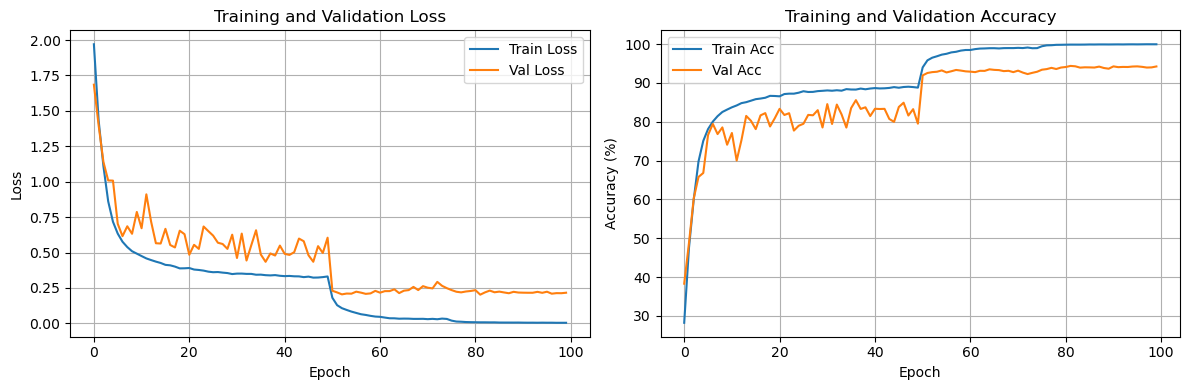

In [34]:
# ==================== Main Training Loop ====================

def main():
    # Hyperparameters
    batch_size = 128
    num_epochs = 100
    learning_rate = 0.1
    momentum = 0.9
    weight_decay = 5e-4

    # Prepare data
    print("Preparing data loaders...")
    train_loader, val_loader, test_loader = get_data_loader(batch_size)

    # Initialize model
    print("Initializing ResNet-18 model...")
    model = ResNet18(num_classes=10).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 75], gamma=0.1)

    # Train history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    best_val_acc = 0.0

    # Training loop
    print('\nStarting training...')
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print(f"\nLearning rate: {scheduler.get_lr()[0]:.6f}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet18_cifar10.pth")
            print(f"Model saved! Best Val Accuracy: {best_val_acc:.2f}%")

    print("\n" + "="*50)
    print("Loading best model for testing...")
    model.load_state_dict(torch.load("best_resnet18_cifar10.pth"))
    test_acc = test(model, test_loader, criterion, device)

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    print("\nTraining history plot saved as 'training_history.png'")

    return model, history


if __name__ == '__main__':
    model, history = main()